### Paired RDD (k:v)

In [2]:
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql.types import *

spark = SparkSession.builder.appName('Paired_RDD').getOrCreate()

In [3]:
temp   =  ['b' , 'd', 'm', 't', 'e', 'u']

rdd_1 = spark.sparkContext.parallelize(temp,2)

# 判断字符是否为元音字母

def vowelCheckFunction( data) :
     if data in ['a','e','i','o','u']:
        return 1
     else :
        return 0

vowelCheckFunction('a'),vowelCheckFunction('b')

(1, 0)

In [4]:
# add new column

rdd_2 = rdd_1.map(lambda data: (data, vowelCheckFunction(data)))

rdd_2.collect()

[('b', 0), ('d', 0), ('m', 0), ('t', 0), ('e', 1), ('u', 1)]

In [7]:
rdd_1.keys().collect()

['b', 'd', 'm', 't', 'e', 'u']

In [8]:
rdd_2.values().collect()

[0, 0, 0, 0, 1, 1]

### 聚合(Agg)

In [4]:
temp = [['A','100W',605],
                 ['B','100W',683],
                 ['B','100W',691],
                 ['B','200W',561],
                 ['A','200W',530],
                 ['A','100W',619],
                 ['B','100W',686],
                 ['B','200W',600],
                 ['B','100W',696],
                 ['A','200W',579],
                 ['A','200W',520],
                 ['A','100W',622],
                 ['A','100W',668],
                 ['B','200W',569],
                 ['B','200W',555],
                 ['A','200W',541]]

rdd = spark.sparkContext.parallelize(temp, 2)

rdd.take(3)

[['A', '100W', 605], ['B', '100W', 683], ['B', '100W', 691]]

In [5]:
rdd_1 = rdd.map(lambda x: (x[0], x[2]))     # key : value  rdd

rdd_1.take(2)

[('A', 605), ('B', 683)]

In [6]:
rdd_2 = rdd_1.map(lambda x: [x[0], [x[1], 1]])

rdd_2.take(2)

[['A', [605, 1]], ['B', [683, 1]]]

#### reduceByKey()

In [7]:
# count by key
# reduceBykey = df.groupby('key').agg(F.sum('col_1')
rdd_2.reduceByKey(lambda l1, l2 : [l1[0]+l2[0], l1[1]+l2[1]]).take(2)

[('A', [4684, 8]), ('B', [5041, 8])]

In [8]:
# count 
rdd_2.reduceByKey(lambda l1, l2 : [l1[0],l2[0], l1[1],l2[1]]).take(2)

[('A', [605, 579, 619, 541]), ('B', [683, 696, 600, 555])]

In [9]:
rdd_3 = rdd_2.reduceByKey(lambda l1, l2 : [l1[0]+l2[0], l1[1]+l2[1]])

rdd_3.map(lambda l : [[0], float(l[1][0])/l[1][1], l[1][1]]).collect()

[[[0], 585.5, 8], [[0], 630.125, 8]]

### 连接(Join)

In [10]:
data_a  = [['si1','Robin','M'],
           ['si2','Maria','F'],
           ['si3','Julie','F'],
           ['si4','Bob',  'M'],
           ['si6','William','M']]

data_b = [['si1','Python'],
          ['si3','Java'],
          ['si1','Java'],
          ['si2','Python'],
          ['si3','Ruby'],
          ['si4','C++'],
          ['si5','C'],
          ['si4','Python'],
          ['si2','Java']]

rdd_a = spark.sparkContext.parallelize(data_a, 2)

rdd_b = spark.sparkContext.parallelize(data_b, 2)

rdd_a2 = rdd_a.map(lambda val: (val[0], [val[1], val[2]]))
rdd_a2.take(3)

[('si1', ['Robin', 'M']), ('si2', ['Maria', 'F']), ('si3', ['Julie', 'F'])]

In [11]:
# join rdd_a and rdd_b
a_join_b = rdd_a.join(rdd_b)

a_join_b.collect()

[('si4', ('Bob', 'C++')),
 ('si4', ('Bob', 'Python')),
 ('si3', ('Julie', 'Java')),
 ('si3', ('Julie', 'Ruby')),
 ('si1', ('Robin', 'Python')),
 ('si1', ('Robin', 'Java')),
 ('si2', ('Maria', 'Python')),
 ('si2', ('Maria', 'Java'))]

In [12]:
# left out join
rdd_a.leftOuterJoin(rdd_b).collect()

[('si4', ('Bob', 'C++')),
 ('si4', ('Bob', 'Python')),
 ('si6', ('William', None)),
 ('si3', ('Julie', 'Java')),
 ('si3', ('Julie', 'Ruby')),
 ('si1', ('Robin', 'Python')),
 ('si1', ('Robin', 'Java')),
 ('si2', ('Maria', 'Python')),
 ('si2', ('Maria', 'Java'))]

In [13]:
# right out join
rdd_a.rightOuterJoin(rdd_b).collect()

[('si4', ('Bob', 'C++')),
 ('si4', ('Bob', 'Python')),
 ('si3', ('Julie', 'Java')),
 ('si3', ('Julie', 'Ruby')),
 ('si5', (None, 'C')),
 ('si1', ('Robin', 'Python')),
 ('si1', ('Robin', 'Java')),
 ('si2', ('Maria', 'Python')),
 ('si2', ('Maria', 'Java'))]

In [14]:
# 全连接
rdd_a.fullOuterJoin(rdd_b).collect()

[('si4', ('Bob', 'C++')),
 ('si4', ('Bob', 'Python')),
 ('si6', ('William', None)),
 ('si3', ('Julie', 'Java')),
 ('si3', ('Julie', 'Ruby')),
 ('si5', (None, 'C')),
 ('si1', ('Robin', 'Python')),
 ('si1', ('Robin', 'Java')),
 ('si2', ('Maria', 'Python')),
 ('si2', ('Maria', 'Java'))]

### Page Rank

In [46]:
# Page rank algorithm

pageLinks =  [['a' ,['b','c','d']],
              ['b', ['d','c','e']],
              ['c', ['b','a']],
              ['d', ['a','c','f']],
              ['e', ['a','b','f']],
              ['f', ['a','c','e']]]
pageRanks =  [['a',1],
              ['b',2],
              ['c',1],
              ['d',2],
              ['e',1],
              ['f',2]]
# calculate contributions.
def rankContribution(uris, rank):
    numberOfUris = len(uris)
    rankContribution = float(rank) / numberOfUris
    newrank =[]
    for uri in uris:
        newrank.append((uri, rankContribution))
    return newrank

In [47]:
# Creating paired RDDs.

pageLinksRDD  = spark.sparkContext.parallelize(pageLinks, 2)

pageRanksRDD  = spark.sparkContext.parallelize(pageRanks, 2)

# Creating loop for page rank updation.

numIter = 20
s = 0.85

#### 一次迭代的过程

In [48]:
linksrank = pageLinksRDD.join(pageRanksRDD)
linksrank.collect()

[('b', (['d', 'c', 'e'], 2)),
 ('c', (['b', 'a'], 1)),
 ('a', (['b', 'c', 'd'], 1)),
 ('e', (['a', 'b', 'f'], 1)),
 ('d', (['a', 'c', 'f'], 2)),
 ('f', (['a', 'c', 'e'], 2))]

In [49]:
# map
linksrank.map(lambda x: rankContribution(x[1][0], x[1][1])).collect()

[[('d', 0.6666666666666666),
  ('c', 0.6666666666666666),
  ('e', 0.6666666666666666)],
 [('b', 0.5), ('a', 0.5)],
 [('b', 0.3333333333333333),
  ('c', 0.3333333333333333),
  ('d', 0.3333333333333333)],
 [('a', 0.3333333333333333),
  ('b', 0.3333333333333333),
  ('f', 0.3333333333333333)],
 [('a', 0.6666666666666666),
  ('c', 0.6666666666666666),
  ('f', 0.6666666666666666)],
 [('a', 0.6666666666666666),
  ('c', 0.6666666666666666),
  ('e', 0.6666666666666666)]]

In [50]:
linksrank.flatMap(lambda x: rankContribution(x[1][0], x[1][1])).collect()

[('d', 0.6666666666666666),
 ('c', 0.6666666666666666),
 ('e', 0.6666666666666666),
 ('b', 0.5),
 ('a', 0.5),
 ('b', 0.3333333333333333),
 ('c', 0.3333333333333333),
 ('d', 0.3333333333333333),
 ('a', 0.3333333333333333),
 ('b', 0.3333333333333333),
 ('f', 0.3333333333333333),
 ('a', 0.6666666666666666),
 ('c', 0.6666666666666666),
 ('f', 0.6666666666666666),
 ('a', 0.6666666666666666),
 ('c', 0.6666666666666666),
 ('e', 0.6666666666666666)]

In [51]:
# reduceByKey
linksrank.flatMap(lambda x: rankContribution(x[1][0], x[1][1])).reduceByKey(lambda v1, v2: v1+v2).collect()

[('c', 2.333333333333333),
 ('b', 1.1666666666666665),
 ('e', 1.3333333333333333),
 ('a', 2.1666666666666665),
 ('d', 1.0),
 ('f', 1.0)]

In [52]:
# * s
linksrank.flatMap(lambda x: rankContribution(x[1][0], x[1][1])).reduceByKey(lambda v1, v2: v1+v2).map(lambda x: (x[0],(1-s)+s*x[1])).collect()

[('c', 2.133333333333333),
 ('b', 1.1416666666666666),
 ('e', 1.2833333333333332),
 ('a', 1.9916666666666667),
 ('d', 1.0),
 ('f', 1.0)]

In [57]:
# 10 轮迭代后PR值的变化
# record_dict 记录PR的变化情况
record_dict = {'a':[1], 'b':[2], 'c':[1], 'd':[2],'e':[1], 'f':[2]}
for i in range(10):
    linksRank = pageLinksRDD.join(pageRanksRDD)
    contributedRDD = linksRank.flatMap(lambda x : rankContribution(x[1][0],x[1][1]))
    sumRanks = contributedRDD.reduceByKey(lambda v1,v2 : v1+v2)
    pageRanksRDD = sumRanks.map(lambda x : (x[0],(1-s)+s*x[1]))
    for page, rank in list(pageRanksRDD.collect()):
        record_dict[page].append(rank)

pageRanksRDD.collect()

[('f', 0.5899136545120213),
 ('d', 0.8778202278629172),
 ('b', 1.2614387993919274),
 ('c', 1.293730163938056),
 ('e', 0.674618225080884),
 ('a', 1.3069858329638677)]

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

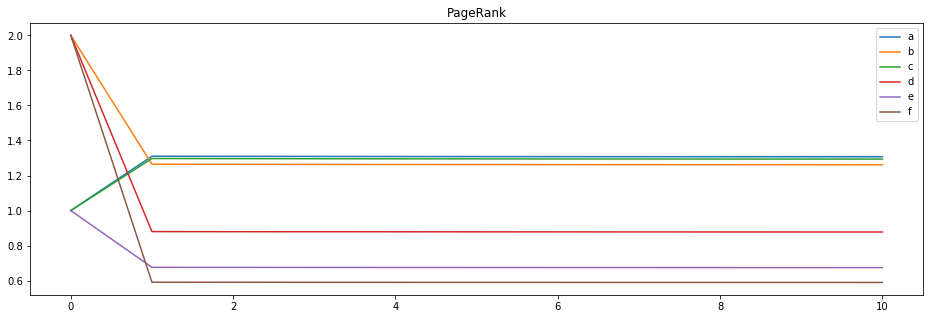

In [61]:
plt.figure(figsize=(16, 5))
plt.title('PageRank')
for k in record_dict.keys():
    plt.plot(record_dict[k], label=k)
plt.legend()